# Latent Space Interpolation Demo (MNIST digit)
- In this notebook, we will load a pre-trained LaDDer model for MNIST digit dataset. 
- We will then interpolate between a pair of MNIST images over k=5 steps, using the following two methods:
  - shortest path (SP) method, which linearly interpolates between the two images in the latent space
  - shortest likelihood path (SLP) method (**our proposal**), which considers the derived data manifold in the latent space and only interpolates samples with high likelihood.  
- We will visualise the interpolated images in the 2D latent space between the two methods to show the difference in the interpolated paths. 

### Here you select some hyper-parameters for the interpolation task
- initialised_method: we initialise the path as a linear interpolation 
- n_step: the number of interpolated images to be generated

In [1]:
initialise_method = 'straight_line'
n_step = 8

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import random

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, ion, show, savefig, cla, figure
from matplotlib.patches import Ellipse
import matplotlib._color_data as mcd
matplotlib.rcParams.update({'font.size': 16})

from sklearn.mixture import GaussianMixture
from scipy.stats import norm, multivariate_normal
# %matplotlib notebook

In [3]:
# import sys
# sys.path.append("..")

from codes.utils import process_config, create_dirs, get_args, count_trainable_variables
from codes.data_loader import DataGenerator
from codes.models import MNISTModel_digit, MNISTModel_fashion, CelebAModel_densenet
from codes.trainers import MNISTTrainer_joint_training, CelebATrainer_joint_training
from demo.demo_tools import *

This interpolation demo does **not** require GPU to run.

In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print("Available device is {}".format(get_available_gpus()))

Available device is []


## Load the pre-trained model
We provided pre-trained models for all 3 datasets in `../pretrained_models/` folder.

Please specify the dataset name (in the variable `exp_name` below) of which you want to load the corresponding model.  

In [5]:
# specify the dataset that you want to interpolate
# the current code only works with mnist datasets.
# the demo for celebA dataset will be created in another demo. 
exp_name = 'mnist_digit' # 'mnist_fashion' or 'celebA'

In [6]:
config = process_config('demo/{}_config.json'.format(exp_name))

# create the experiments dirs
create_dirs([config['result_dir'], config['checkpoint_dir']])

# create tensorflow session
sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True
sess = tf.Session(config=sess_config)

# create your data generator
data = DataGenerator(config, sess)

The current config is:
{'exp_name': 'mnist_digit', 'loss_function': 'ELBO', 'prior': 'ours', 'inner_activation': 'leaky_relu', 'n_mixtures': 50, 'GM_fit_restart': 1, 'n_MC_samples': 100, 'load_model': 1, 'load_dir': './pretrained_models/', 'num_epochs': 30, 'use_mask_start': 50, 'sg_pretraining': 10, 'num_iter_to_plot': 2, 'accurate_fit': 10, 'kernel_size': 3, 'learning_rate_ae': 0.0003, 'learning_rate_sigma': 0.0005, 'learning_rate_prior': 0.0003, 'learning_rate_inner_sigma': 0.0002, 'batch_size': 256, 'max_to_keep': 1, 'dim_input_x': 28, 'dim_input_y': 28, 'dim_input_channel': 1, 'code_size': 16, 'representation_size': 2, 'TRAIN_VAE': 1, 'TRAIN_sigma': 1, 'TRAIN_prior': 1, 'TRAIN_inner_sigma': 1, 'TRAIN_decoded_z_std': 0, 'sigma': 0.5, 'inner_sigma': 0.1, 'inner_sigma_ub': 0.1, 'inner_sigma_lb': 0.05, 'latent_variance_precision': 0.001, 'num_hidden_units': 256, 'num_hidden_units_inner_VAE': 512, 'n_layers_inner_VAE': 5}

Experiment results will be saved at:
prior-ours-256-16-2-leaky_

In [7]:
# build the laDDer model
if config['exp_name'] == "mnist_digit":
    model = MNISTModel_digit(config)
elif config['exp_name'] == "mnist_fashion":
    model = MNISTModel_fashion(config)
elif config['exp_name'] == "celeba":
    model = CelebAModel_densenet(config)

# create a trainer
if config['exp_name'] in ["mnist_digit", "mnist_fashion"]:
    trainer = MNISTTrainer_joint_training(sess, model, data, config)
    sess.run(model.iterator.initializer,
             feed_dict={model.original_signal: data.train_set['image'],
                        model.seed: trainer.cur_epoch})
elif config['exp_name'] == "celeba":
    trainer = CelebATrainer_joint_training(sess, model, data, config)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
finish encoder:
Tensor("Mult

gvs prior: [(<tf.Tensor 'gradients_2/prior/dense/MatMul_grad/tuple/control_dependency_1:0' shape=(16, 512) dtype=float32>, <tf.Variable 'prior/dense/kernel:0' shape=(16, 512) dtype=float32_ref>), (<tf.Tensor 'gradients_2/prior/dense/BiasAdd_grad/tuple/control_dependency_1:0' shape=(512,) dtype=float32>, <tf.Variable 'prior/dense/bias:0' shape=(512,) dtype=float32_ref>), (<tf.Tensor 'gradients_2/prior/dense_1/MatMul_grad/tuple/control_dependency_1:0' shape=(512, 512) dtype=float32>, <tf.Variable 'prior/dense_1/kernel:0' shape=(512, 512) dtype=float32_ref>), (<tf.Tensor 'gradients_2/prior/dense_1/BiasAdd_grad/tuple/control_dependency_1:0' shape=(512,) dtype=float32>, <tf.Variable 'prior/dense_1/bias:0' shape=(512,) dtype=float32_ref>), (<tf.Tensor 'gradients_2/prior/dense_2/MatMul_grad/tuple/control_dependency_1:0' shape=(512, 512) dtype=float32>, <tf.Variable 'prior/dense_2/kernel:0' shape=(512, 512) dtype=float32_ref>), (<tf.Tensor 'gradients_2/prior/dense_2/BiasAdd_grad/tuple/control_

In [8]:
# load model if exists
model.load(sess, model="VAE")
if config['prior'] in ["ours", 'hierarchical', 'vampPrior']:
    model.load(sess, model="prior")


checkpoint_dir to be loaded:
./pretrained_models/mnist_digit

INFO:tensorflow:Restoring parameters from ./pretrained_models/mnist_digit/vae-model
Outer VAE model loaded.

checkpoint_dir to be loaded:
./pretrained_models/mnist_digit

INFO:tensorflow:Restoring parameters from ./pretrained_models/mnist_digit/prior-model
Prior model loaded.


### Here we fit a GMM hyper prior for our model using 20k training images.

Initialization 0
  Iteration 100	 time lapse 6.84777s	 ll change 0.63052
  Iteration 200	 time lapse 6.65069s	 ll change 0.26908
  Iteration 300	 time lapse 6.61812s	 ll change 0.02414
Initialization converged: True	 time lapse 21.10669s	 ll -14996.63527
There are 26 active mixtures.
The current GM prior estimate has following weights:
[0.0459237  0.02824621 0.05098917 0.02012421 0.01125208 0.02146165
 0.06145395 0.03149927 0.03632885 0.03715875 0.04850596 0.01329667
 0.02901254 0.03773677 0.03516612 0.05593033 0.05357621 0.05743433
 0.02934152 0.0414436  0.02633094 0.01055222 0.01354024 0.04123937
 0.03342721 0.07327411]
Final fitted prior saved.


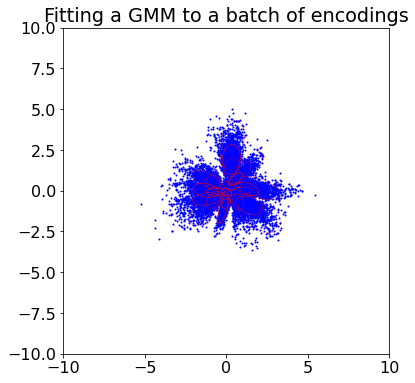

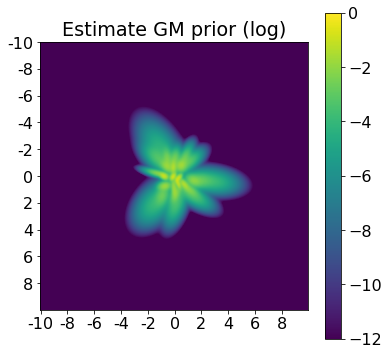

In [9]:
# fit a GMM hyper prior 
if config['prior'] == "ours":
    samples = trainer.fit_GMM_VI(iterator=model.input_image, mode="accurate", space="t")
    if config['representation_size'] == 2:
        trainer.plot_prior_distribution(samples, mode="accurate-GM", style='circle', show_img=True)
        trainer.plot_prior_distribution(samples, mode="accurate-GM", style='density', show_img=True)
elif config['prior'] == "GMM":
    samples = trainer.fit_GMM_VI(iterator=model.input_image, mode="accurate", space="z")
    if config['code_size'] == 2:
        trainer.plot_prior_distribution(samples, mode="accurate-GM", style='circle', show_img=True)
        trainer.plot_prior_distribution(samples, mode="accurate-GM", style='density', show_img=True)

if config['prior'] in ['ours', 'GMM']:
    GM = dict()
    GM['m'] = (trainer.GM_prior_final.means_).astype(np.float32)
    GM['K'] = (trainer.GM_prior_final.covariances_).astype(np.float32)
    GM['w'] = (trainer.GM_prior_final.weights_).astype(np.float32)
else:
    GM = None

prior = define_prior_distribution(config, sess, model, gmm_info=GM)

### Here you select the two images that you want to interpolate between.

Start sample:


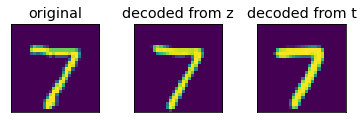

Target sample:


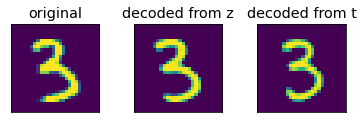

In [10]:
# Get two query images - start and end of interpolation 
# please feel free to use different indices to try out different interpolation result 
save_dir = config['result_dir']

idx_start = 0
print("Start sample:")
embedding_start = get_embeddings_from_val_set(idx_start, config, exp_name, sess, data, model, trainer, 
                                              save_plot=False)

idx_end = 32
print("Target sample:")
embedding_end = get_embeddings_from_val_set(idx_end,  config, exp_name, sess, data, model, trainer, 
                                            save_plot=False)

## Our shortest likelihood path interpolation starts here.
- We first initialise the path using a linear path.
- We then define the interpolation objective as shown in Eq (9) in our paper.
- We then use AdamOptimizer to optimise the objective for 500 iterations. 
- The optimised embeddings correspond to the interpolated images. 

In [11]:
# Define an optimisation objective 
# Generate a set of random embeddings as initialisation
if initialise_method == 'random':
    initialised_embeddings = generate_prior_embeddings(prior, n_embeddings=n_step)
else: 
    initialised_embeddings = np.linspace(embedding_start, embedding_end, n_step+1, endpoint=False)[1:]
# print(initialised_embeddings.shape)
# print(initialised_embeddings[0])

# Define tf.Variables for the 5 points in the intermediate steps
with tf.variable_scope('interpolation'):
    pts = tf.Variable(initialised_embeddings, dtype=tf.float32, trainable=True, name='intermediate_pts')

# Compute the path length (Euclidean)
pts_with_start = tf.concat([tf.expand_dims(embedding_start, 0), pts], axis=0)
pts_with_end = tf.concat([pts, tf.expand_dims(embedding_end, 0)], axis=0)
segment_length = tf.sqrt(tf.reduce_sum(tf.square(pts_with_end - pts_with_start), axis=1))
equal_length_constraint = tf.math.reduce_std(segment_length)
entire_path_length = tf.reduce_sum(segment_length)

# Evaluate the likelihood along the path
neg_ll = - tf.reduce_sum(prior.log_prob(pts))

w_equal_length = tf.placeholder(tf.float32, [])
w_path_dist = tf.placeholder(tf.float32, [])

# Overall objective
interpolation_obj = w_path_dist * entire_path_length + w_equal_length * equal_length_constraint + neg_ll

In [12]:
w_step_size = 100
w_shortest_path = 10

# Define optimisation step
interpolation_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "interpolation")
num_interpolation = count_trainable_variables('interpolation')

lr_interpolation = tf.placeholder(tf.float32, [])
opt_interpolation = tf.train.AdamOptimizer(learning_rate=lr_interpolation,
                                beta1=0.9,
                                beta2=0.95)
sess.run(tf.variables_initializer(opt_interpolation.variables()))
gvs_interpolation = opt_interpolation.compute_gradients(interpolation_obj, var_list=interpolation_vars)
print('gvs interpolation: {}'.format(gvs_interpolation))
capped_gvs_interpolation = [(model.ClipIfNotNone(grad), var) for grad, var in gvs_interpolation]

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    update_step_interpolation = opt_interpolation.apply_gradients(capped_gvs_interpolation)

The total number of trainable parameters in the interpolation model is: 0.02k.
gvs interpolation: [(<tf.Tensor 'gradients_4/AddN_2:0' shape=(8, 2) dtype=float32>, <tf.Variable 'interpolation/intermediate_pts:0' shape=(8, 2) dtype=float32_ref>)]


In [13]:
# Generate a set of random embeddings as initialisation
if initialise_method == 'random':
    initialised_embeddings = generate_prior_embeddings(prior, n_embeddings=n_step)
pts.assign(initialised_embeddings)

sess.run(pts.initializer)
sess.run(tf.variables_initializer(opt_interpolation.variables()))

Iter 100/500: cur loss is 36.488426208496094
Iter 200/500: cur loss is 36.37263488769531
Iter 300/500: cur loss is 36.30289077758789
Iter 400/500: cur loss is 36.35979461669922
Iter 500/500: cur loss is 36.34639358520508
Step variance is 0.00229788850992918
Losses in our interpolation objective are optimised as below:


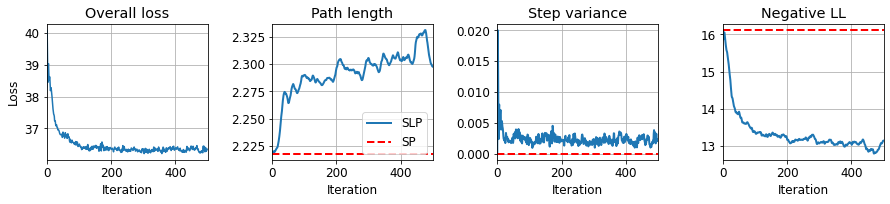

In [14]:
# Optimisation over certain iterations
n_iter = 500
cur_lr = 1e-2
n_iter_print = 100

loss = []
pts_record = []
step_var_record = []
path_length_record = []
neg_ll_record = []
feed_dict = {lr_interpolation: cur_lr,
             w_equal_length: w_step_size,
             w_path_dist: w_shortest_path,
             model.original_signal: trainer.test_batch}
for i in range(n_iter):
    cur_loss, cur_pts, cur_step_var, cur_path_length, cur_ll, _ = sess.run([interpolation_obj,
                                     pts,
                                     equal_length_constraint,
                                     entire_path_length,
                                     neg_ll,
                                     update_step_interpolation], feed_dict=feed_dict)
    loss.append(cur_loss)
    pts_record.append(cur_pts)
    step_var_record.append(cur_step_var)
    path_length_record.append(cur_path_length)
    neg_ll_record.append(cur_ll)
    if i % n_iter_print == n_iter_print-1:
        print("Iter {}/{}: cur loss is {}".format(i+1, n_iter, cur_loss))
print("Step variance is {}".format(cur_step_var))

print("Losses in our interpolation objective are optimised as below:")
plot_interpolation_losses(loss, path_length_record, step_var_record, neg_ll_record, n_iter,
                          idx_start, idx_end, n_step, config)

## Here we demonstrate the interpolation results
- We first show the trace of interpolated images under our method.
- We then visualise the interpolated path in the 2D latent space. This is compared with the linear path using shortest path (SP) method. 

SLP interpolation (ours)


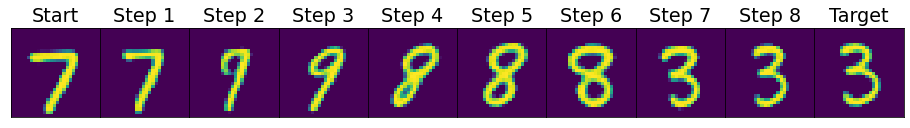

SP interpolation


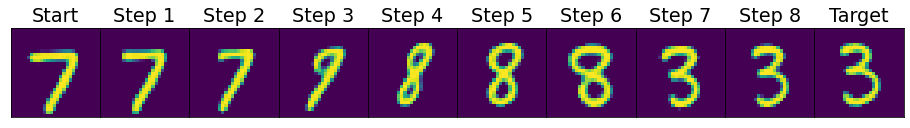

In [15]:
# plot the interpolated images from start image to target image
print("SLP interpolation (ours)")
interpolated_embeddings = np.concatenate(
    [np.expand_dims(embedding_start, 0), cur_pts, np.expand_dims(embedding_end, 0)], axis=0)
plot_interpolated_images(interpolated_embeddings, config, exp_name, sess, data, model, trainer,
                         n_step, idx_start, idx_end, save_plot=True, name_input='SLP')

print("SP interpolation")
interpolated_embeddings = np.concatenate(
    [np.expand_dims(embedding_start, 0), initialised_embeddings, np.expand_dims(embedding_end, 0)], axis=0)
plot_interpolated_images(interpolated_embeddings, config, exp_name, sess, data, model, trainer,
                         n_step, idx_start, idx_end, save_plot=True, name_input='SP')

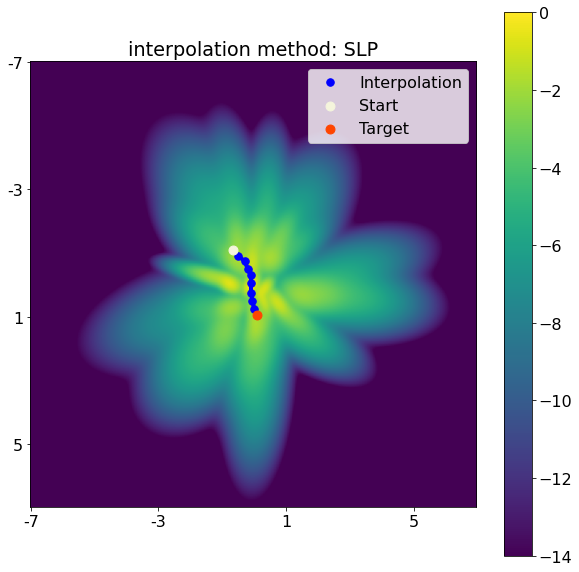

In [16]:
# plot the interplated path in the 2D latent space for our SLP method
plot_optimised_path(
    cur_pts, config, GM, sess, model, trainer,
    embedding_start, embedding_end, idx_start, idx_end, n_step, 
    prior=prior, 
    plot_prior='density', 
    w=2., 
    save_plot=True, 
    grid_size=7, 
    font_size=16,
    name_input='SLP')

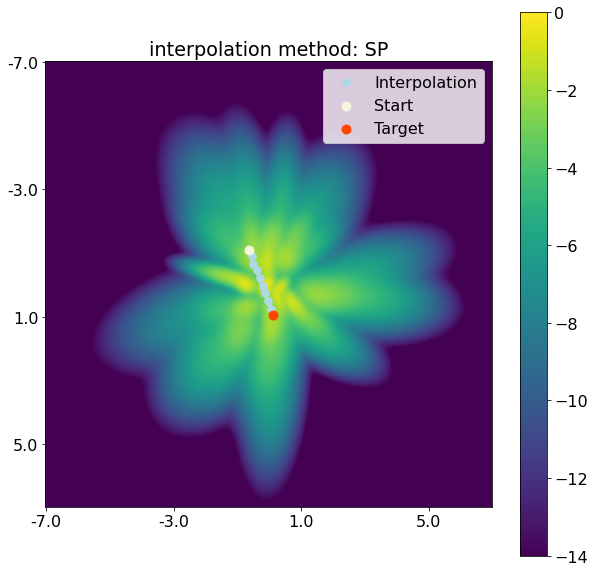

In [17]:
# plot the interplated path in the 2D latent space for the linear SP method
plot_optimised_path(
    initialised_embeddings, config, GM, sess, model, trainer,
    embedding_start, embedding_end, idx_start, idx_end, n_step, 
    prior=prior, 
    plot_prior='density', 
    w=2., 
    save_plot=True, 
    grid_size=7., 
    font_size=16, 
    name_input='SP', 
    c='lightblue')